In [115]:
import os
import sys
import numpy as np
import pandas as pd
import pywt as wt
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import statsmodels
%matplotlib notebook

In [64]:
# Import a random light curve. Time is in days, flux is a relative scale.
lc_x = pd.read_csv('DataV_koi_kplr005706966.csv', names=['time', 'flux', 'e_flux'], 
                   nrows=10500, engine='python')
npt_lsst = np.ceil(np.ptp(lc_x.time.values) / 3).astype('int')
lc_x2 = lc_x[::npt_lsst]

<IPython.core.display.Javascript object>


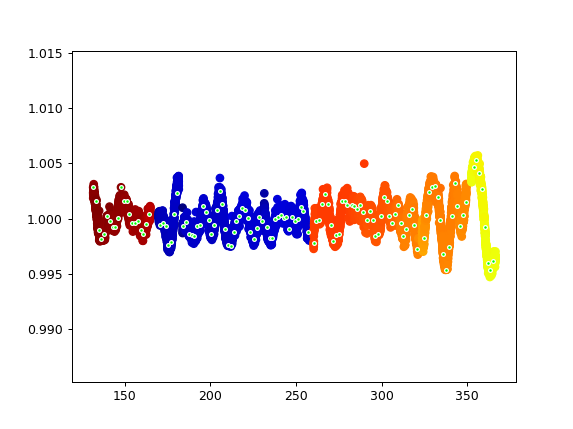

In [65]:
# Quick visualization, both Kepler sample-like and LSST sample-like (best scenario)
plt.scatter(lc_x.time, lc_x.flux, marker='o', c=lc_x.e_flux, cmap='jet')
plt.scatter(lc_x2.time, lc_x2.flux, marker='.', c='lime', edgecolor='w')
plt.show()

<IPython.core.display.Javascript object>


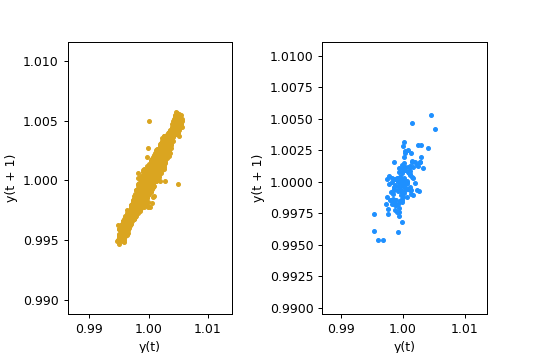

In [90]:
# Quick checking: lag plot should be random for structures with no memory. The correlation here
# is a sanity check
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
lag_plot(lc_x.flux, ax=ax[0], marker='.', c='goldenrod')
lag_plot(lc_x2.flux, ax=ax[1], marker='.', c='dodgerblue')
plt.subplots_adjust(wspace=0.55)

In [ ]:
# Lets create some gaps 

In [128]:
# We need a way of calculate autocorrelation easily
from statsmodels.tsa.stattools import acf
x = acf(lc_x.flux.values, unbiased=False, nlags=len(lc_x.flux.values))
print(len(x))

10500


<IPython.core.display.Javascript object>


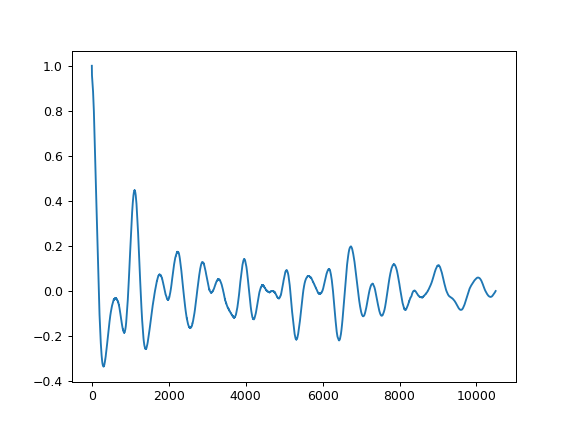

In [126]:
plt.plot(x)